In [12]:
import imageio
import skimage
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from scipy.spatial import Delaunay
from skimage.transform import warp, AffineTransform
from skimage.draw import polygon

(1536, 1536, 3)
(439, 400, 3)


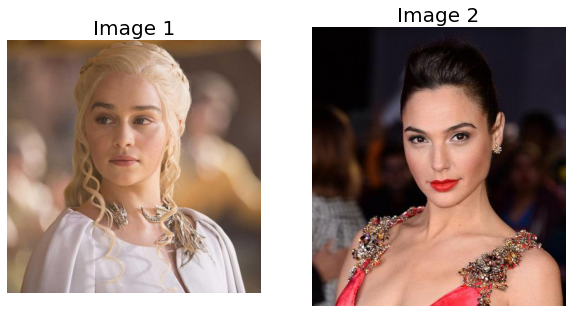

In [13]:
root_folder = os.path.dirname(os.getcwd())                  # get repo root folder
sys.path.insert(0, root_folder)                             # Add root folder to path. Needed so the DIP library can be imported.        
from DIP_Library import featureDetectionDLIB, get_tf_model  # Import the DIP lib

face_folder =  root_folder + "\\resources\\imgs\\faces\\"   # appende image folder
img_name_1 = "daenerys.jpg"                                 # random face as input
img_name_2 = "gal_gadot.jpg"

img1 = imageio.imread(face_folder+img_name_1)               # load the image
img1 = skimage.util.img_as_float(img1)                      # Convert image data type
print(img1.shape)

img2 = imageio.imread(face_folder+img_name_2)               # load the image
img2 = skimage.util.img_as_float(img2) 
print(img2.shape)

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplot(121);plt.title('Image 1',fontsize=20);plt.axis('off');plt.imshow(img1)
plt.subplot(122);plt.title('Image 2',fontsize=20);plt.axis('off');plt.imshow(img2)
model = root_folder + "\\resources\\Models\\shape_predictor_68_face_landmarks.dat"
#model = root_folder + "\\resources\\Models\\shape_predictor_5_face_landmarks.dat"

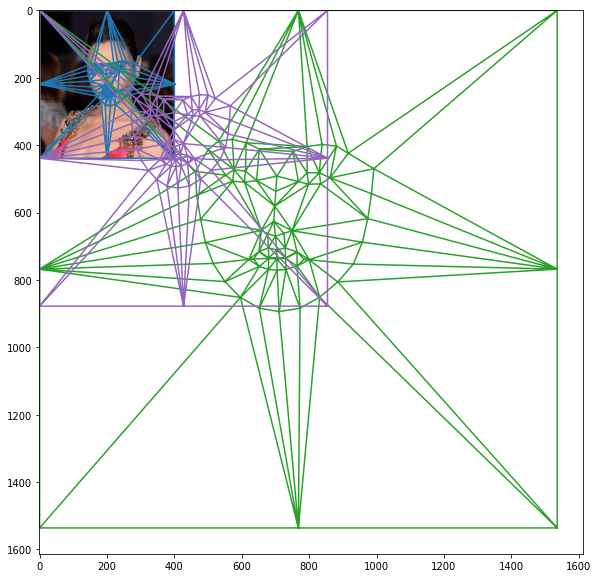

In [14]:
pts1 = featureDetectionDLIB(img1,model, True, True)
pts2 = featureDetectionDLIB(img2,model, True, True)

alpha = 0.6
ptsm = (1-alpha)*pts1 + alpha*pts2

triangles = Delaunay(pts2)
triangles1 = Delaunay(pts1)
triangles2 = Delaunay(ptsm)

fig, (ax) = plt.subplots(nrows=1, ncols=1)
ax.imshow(img2)
ax.triplot(pts2[:,0], pts2[:,1], triangles.simplices)
ax.triplot(pts1[:,0], pts1[:,1], triangles1.simplices)
ax.triplot(ptsm[:,0], ptsm[:,1], triangles2.simplices)   

In [15]:
def get_bounding_box(points):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    Here, we use min and max four times over the collection of points
    """
    top_left_x = int(min(point[0] for point in points))
    top_left_y = int(min(point[1] for point in points))
    bot_right_x = int(max(point[0] for point in points))
    bot_right_y = int(max(point[1] for point in points))

    #return [top_left_x, top_left_y, (bot_right_x-top_left_x), (bot_right_y-top_left_y)]    # Opgave vroeg voor deze output 
    return [top_left_x, top_left_y, bot_right_x, bot_right_y]                               # maar code is duidelijker indien enkel gewerkt wordt met coordinaten

In [16]:
def warp_triangle(img, bbox, tf_M, output_shape):
    """Create a subimage, size of the bbox, from the image. And warp the bounding box to the new bounding box shape

    Args:
        img: a image
        bbox : bounding box of a triangle
        tf_M : Affine transform matrix
        output_shape : shape of the output boundig box derrived from bbm

    Returns:
         Transformed sub_image
    """
    sub_img = img[bbox[1]:bbox[3],bbox[0]:bbox[2]]                                  # Select all pixels from the bounding box  
    transformed = warp(sub_img, tf_M, output_shape=output_shape, mode='reflect')    
    #mode parameter -> {constant, edge, symmetric, reflect, wrap},
    return transformed

In [17]:
def get_triangle_mask(triangle, bbox, output_shape):
    """Generate a mask that isolates the triangle within its bounding box.

    Args:
        triangle : array containing coordinates of the 3 angles
        bbox : bounding box of the triangle
        output_shape : _description_

    Returns:
        _type_: _description_
    """
    mask = np.zeros(output_shape,dtype=np.uint8)
    rr,cc = polygon(triangle[:,0]-(bbox[0]+1), triangle[:,1]-(bbox[1]+1))
    mask[cc,rr]=1
    mask = mask.reshape(*mask.shape,1)
    return mask

In [18]:
def warp_image(img, points, triangles, points_m, imageShape):
    """Warp a image to the given intermediate points_m. To calculate this the size of the second image is also required.

    Args:
        img : image that will be warp to intermediate feature points
        points : points containing cooordinates of features
        triangles : list of generated triangles from points
        points_m : calculated intermediate points
        imageShape : shape of the second image

    Returns:
        _type_: _description_
    """
    warped = np.zeros((max(img.shape[0], imageShape[0]), max(img.shape[1], imageShape[1]),3))
    for tri in triangles.simplices:
        t1 = np.array([points[tri[0]], points[tri[1]], points[tri[2]]],dtype=int)
        tm = np.array([points_m[tri[0]], points_m[tri[1]], points_m[tri[2]]], dtype=int)

        
        bb1 = get_bounding_box(t1)
        bbm = get_bounding_box(tm)

        M = AffineTransform()
        M.estimate(t1-bb1[:2],tm-bbm[:2])        
        
        if not np.linalg.det(M.params): continue
        else: M = np.linalg.inv(M.params)
        
        output_shape = warped[bbm[1]:bbm[3]+1, bbm[0]:bbm[2]+1].shape[:2]

        wt1 = warp_triangle(img, bb1, M, output_shape)
        mask = get_triangle_mask(tm,bbm, output_shape)

        warped[bbm[1]:bbm[3]+1, bbm[0]:bbm[2]+1] = warped[bbm[1]:bbm[3]+1, bbm[0]:bbm[2]+1]*(1-mask)+ mask*wt1
    return warped
    


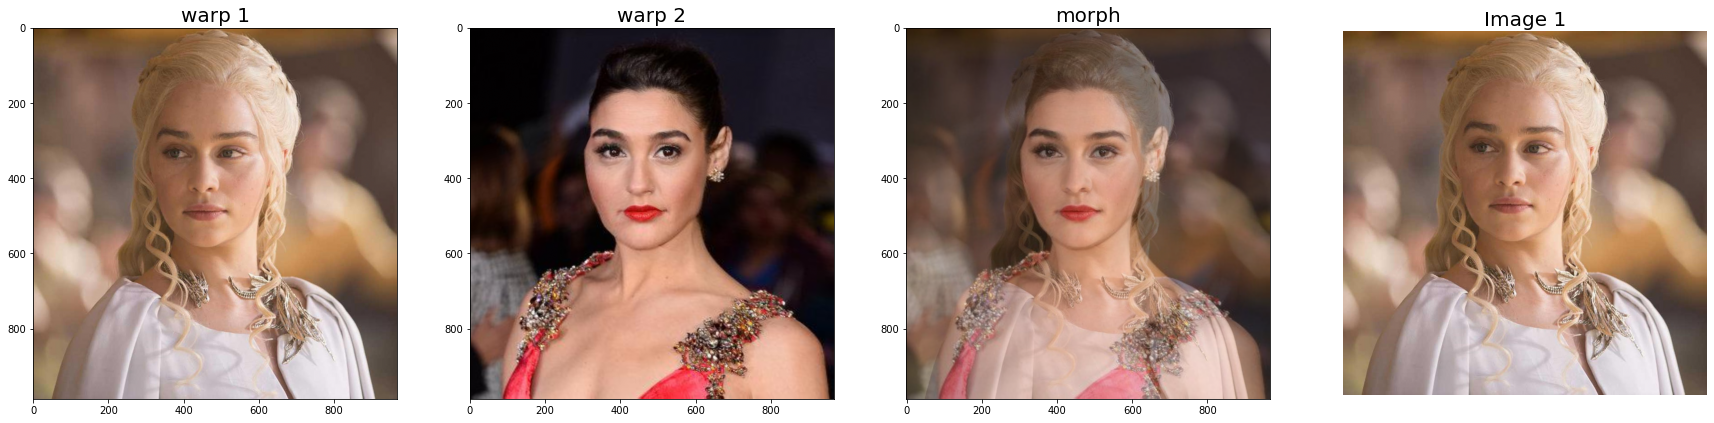

In [24]:
pts1 = featureDetectionDLIB(img1,model, True, True)                 # Generate features
pts2 = featureDetectionDLIB(img2,model, True, True)

alpha = 0.5                                                         # INPUT VALUE
ptsm = (1-alpha)*pts1 + alpha*pts2                                  # Calculate intermediate points

triangles1 = Delaunay(pts1)                                         # Get list of triangles (image1)
warped1 = warp_image(img1, pts1, triangles1,ptsm, img2.shape)       # Warp image


triangles2 = Delaunay(pts2)                                         # Get list of triangles (image2)
warped2 = warp_image(img2, pts2, triangles2,ptsm, img1.shape)       # Warp image

morphed = img_as_ubyte((1-alpha)*warped1 + alpha*warped2)           # Add the 2 warped images together to create a morph


newWidth = int((1-alpha)*img1.shape[0] + alpha*img2.shape[0])       # Calculate the new width and height of the warped images
newHeight = int((1-alpha)*img1.shape[1] + alpha*img2.shape[1])

plt.rcParams['figure.figsize'] = [30, 30]
plt.subplot(141);plt.title('warp 1',fontsize=20);plt.imshow(warped1[0:newWidth, 0:newHeight])
plt.subplot(142);plt.title('warp 2',fontsize=20);plt.imshow(warped2[0:newWidth, 0:newHeight])  
plt.subplot(143);plt.title('morph',fontsize=20);plt.imshow(morphed[0:newWidth, 0:newHeight])
plt.subplot(144);plt.title('Image 1',fontsize=20);plt.axis('off');plt.imshow(img1)
